In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('drive/My Drive/BrentOilPrices.csv')
data.dropna(inplace=True)

In [ ]:
data2 = pd.read_csv('/content/DATASET_FINAL.csv')
data2 = data2.drop('Unnamed: 0', axis=1)

In [ ]:
data2['Date'] = data2['Date'].apply(lambda x: pd.to_datetime(x))
data2.drop([8224])
data2=data2.iloc[::-1]
data2 = data2.reset_index().drop('index', axis=1)
data2 = data2.fillna(0)
data2 = data2[['Date', 'Price']]

In [ ]:
data2

,Date,Price
0,1988-06-27,15.10
1,1988-06-28,15.27
2,1988-06-29,15.47
3,1988-06-30,14.85
4,1988-07-01,14.60
...,...,...
8222,2020-09-14,39.61
8223,2020-09-15,40.53
8224,2020-09-16,42.22
8225,2020-09-17,43.30


In [ ]:
pip install catboost

     |████████████████████████████████| 66.1MB 48kB/s 


In [ ]:
data2['Price_ND']=data2['Price'].shift(-1)
for i in range(1,16):
  data2['Price_LD_{}'.format(i)]=data2['Price'].shift(i)
autoreg_columns = ['Price_LD_{}'.format(i) for i in range(1, 16)]

In [ ]:
data2['moving_mean_all_autoreg'] = data2[autoreg_columns].mean(axis=1)
data2['moving_std_all_autoreg'] = data2[autoreg_columns].std(axis=1)
data2['moving_min_all_autoreg'] = data2[autoreg_columns].min(axis=1)
data2['moving_max_all_autoreg'] = data2[autoreg_columns].max(axis=1)

In [ ]:
data2 = data2.dropna(subset=['Price_ND'], axis=0)
# data2 = data2.fillna(-999)

In [ ]:
#data2.drop('Date',axis=1,inplace=True)

In [ ]:
data2

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,1988-06-27,15.10,15.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-06-28,15.27,15.47,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.100000,NaN,15.10,15.10
2,1988-06-29,15.47,14.85,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.185000,0.120208,15.10,15.27
3,1988-06-30,14.85,14.60,15.47,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.280000,0.185203,15.10,15.47
4,1988-07-01,14.60,14.35,14.85,15.47,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.172500,0.262853,14.85,15.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8221,2020-09-11,39.83,39.61,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,45.13,44.35,43.718667,2.110660,39.78,45.86
8222,2020-09-14,39.61,40.53,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,45.13,43.417333,2.325779,39.78,45.86
8223,2020-09-15,40.53,42.22,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,43.049333,2.467803,39.61,45.86
8224,2020-09-16,42.22,43.30,40.53,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,42.694000,2.417407,39.61,45.64


In [ ]:
def smape(A, F):
  return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop(['Date','Price_ND'], axis=1), data2['Price_ND'], test_size=0.3, shuffle=False)

In [ ]:
cat = CatBoostRegressor(depth=5)

cat.fit(X_train, y_train, eval_set=(X_test, y_test), silent=True)

No handles with labels found to put in legend.


1.8134518538429218


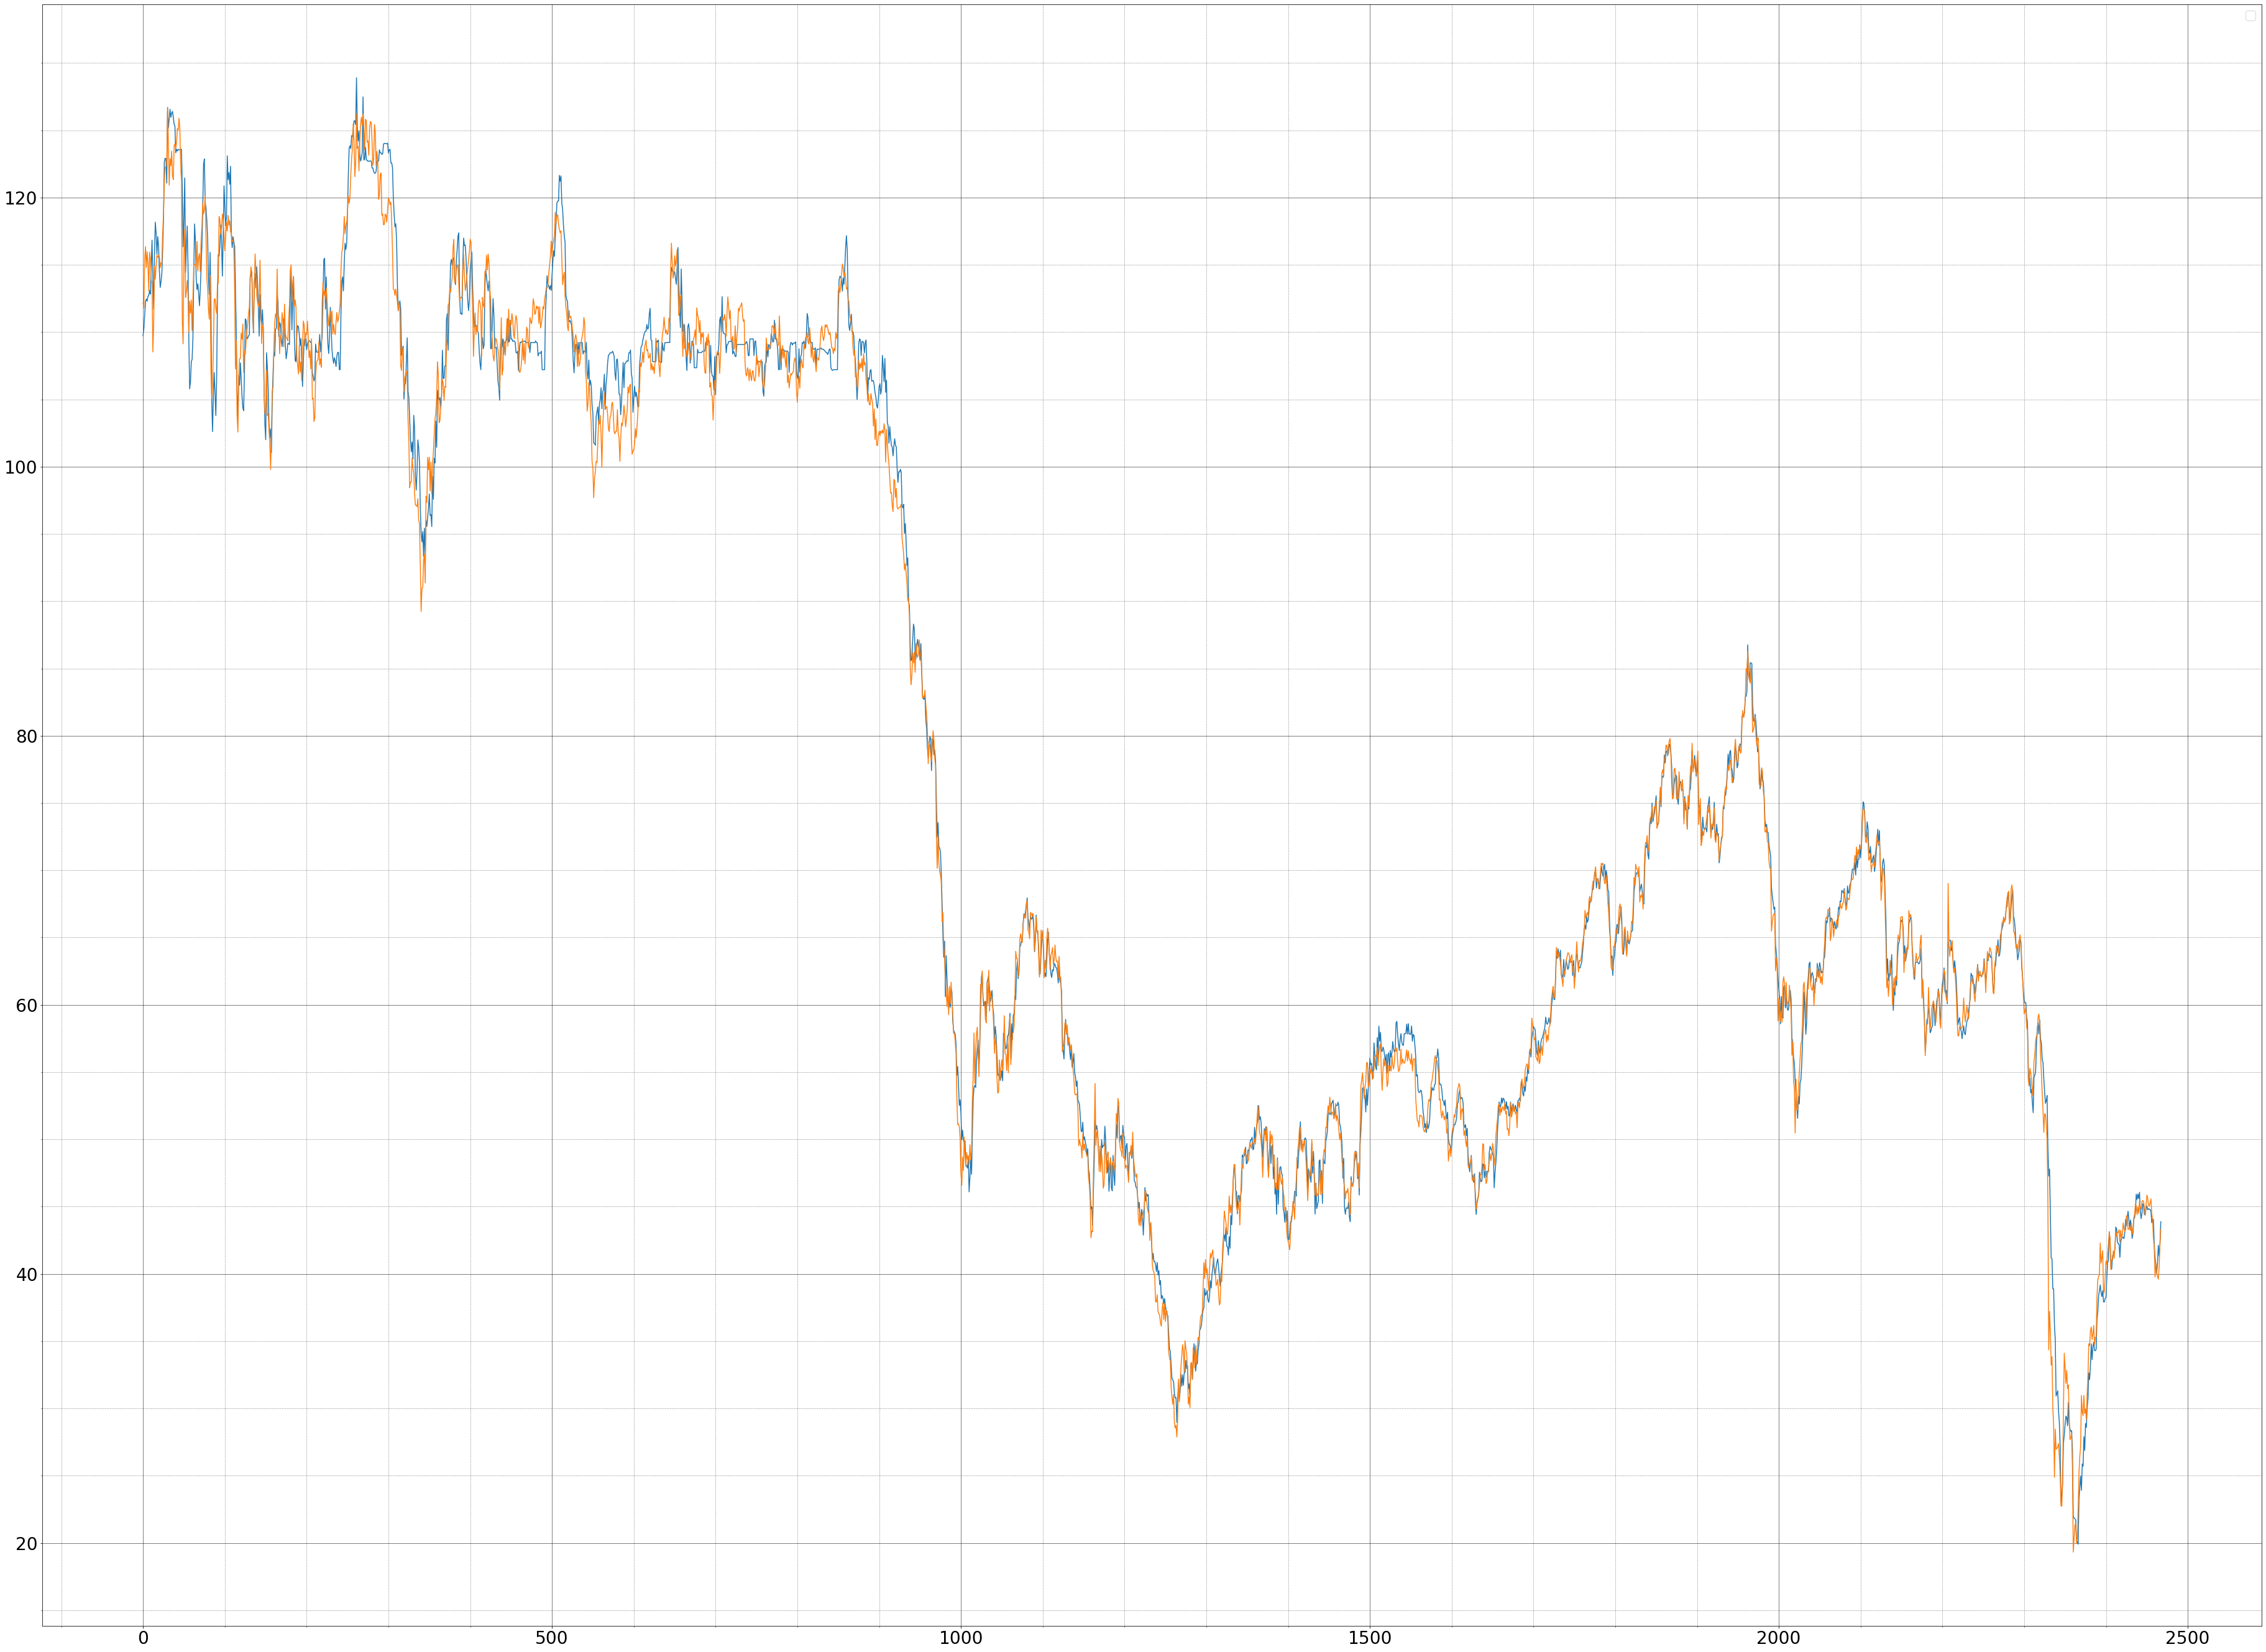

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
# lr.fit(X_train, y_train)
preds = cat.predict(X_test)
print(smape(preds, X_test['Price']))

fig = plt.figure(figsize=(64, 48))
plt.legend(prop={'size': 20})
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.grid(which='major', color='k',  linewidth = 0.5)
plt.grid(which='minor', color='k',  linestyle = ':', linewidth=0.5)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.plot(list(range(len(preds))), preds, label='preds')
plt.plot(list(range(len(preds))), X_test['Price'], label='real')

plt.savefig('graph1.jpeg', dpi=300)

In [ ]:
def comp(pred,y):
  return sum(pred==y)/len(y)
  # 17:35 -- 17:44 -- 17:51
  # в среднем 9 минут на один фит
from sklearn.model_selection import KFold
import xgboost
kf = KFold(n_splits=20, shuffle=False)
train_proba_list = []
test_proba_list = []
train = data2.drop(['Date','Price_ND'], axis=1)
y = data2['Price_ND']
models = []
for train_val,test_val in kf.split(train):
  model = CatBoostRegressor(depth=5, silent=True)
  model.fit(train.iloc[train_val], y.iloc[train_val])
  print(comp(model.predict(train.iloc[test_val]),y.iloc[test_val]))
  models.append(model)
  train_proba_list.append(model.predict(train)) 


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
 models

In [ ]:
train_preds_clf = np.vstack(train_proba_list).T
df_train_clf = pd.DataFrame(data=train_preds_clf, index=train.index)

In [ ]:
np.mean(df_train_clf, axis=1)

0       14.382123
1       15.087132
2       14.834109
3       14.707640
4       14.656977
          ...    
8221    40.497489
8222    40.885863
8223    41.366068
8224    42.256283
8225    43.158726
Length: 8226, dtype: float64

In [ ]:
data2

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,1988-06-27,15.10,15.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-06-28,15.27,15.47,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.100000,NaN,15.10,15.10
2,1988-06-29,15.47,14.85,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.185000,0.120208,15.10,15.27
3,1988-06-30,14.85,14.60,15.47,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.280000,0.185203,15.10,15.47
4,1988-07-01,14.60,14.35,14.85,15.47,15.27,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.172500,0.262853,14.85,15.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8221,2020-09-11,39.83,39.61,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,45.13,44.35,43.718667,2.110660,39.78,45.86
8222,2020-09-14,39.61,40.53,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,45.13,43.417333,2.325779,39.78,45.86
8223,2020-09-15,40.53,42.22,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,45.86,43.049333,2.467803,39.61,45.86
8224,2020-09-16,42.22,43.30,40.53,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,45.09,45.64,42.694000,2.417407,39.61,45.64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
mod = RandomForestRegressor(n_estimators=5, max_depth=3)
mod.fit(df_train_clf, y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# lr.predict(np.array(data2.tail(2).drop('Price_ND',axis=1).iloc[1]).reshape(1,-1))

In [ ]:
from datetime import datetime
from datetime import date
def days_between(d1, d2):
  return abs((datetime(d2.year, d2.month, d2.day) - datetime(d1.year, d1.month, d1.day)).days)

In [ ]:
def bayes(mu, sigma):
  mu, sigma = mu, sigma # mean and standard deviation
  return np.random.normal(mu, sigma, 1)
  

In [ ]:
def uni(upper, higher):
  return np.random.uniform(upper, higher)

In [ ]:
bayes(0, 0.15)

array([0.08981558])

In [ ]:
def predictor(date, ensemble, model, data, step=None, alpha=0.8, beta=0.6, boosty=False):
  current_raw = pd.DataFrame(data=np.zeros(shape=(1,len(data.columns))), columns=data.columns)
  date = pd.to_datetime(date)
  start_date = data.tail(1)['Date'].iloc[0]
  difference = days_between(start_date, date)
  autoreg_columns = ['Price_LD_{}'.format(i) for i in range(1, 16)]
  prob_list = []
  for i in range(0, difference):
    current_raw['Date'] = start_date + pd.Timedelta(days=i+1)
    for j in range(0,15):
      current_raw['Price_LD_{}'.format(j+1)]=data['Price'].shift(j).iloc[-1]

    current_raw['Price'] = data.tail(1)['Price_ND'].iloc[0]
    

    current_raw['moving_mean_all_autoreg'] = current_raw[autoreg_columns].mean(axis=1)
    current_raw['moving_std_all_autoreg'] = current_raw[autoreg_columns].std(axis=1)
    current_raw['moving_min_all_autoreg'] = current_raw[autoreg_columns].min(axis=1)
    current_raw['moving_max_all_autoreg'] = current_raw[autoreg_columns].max(axis=1)

    for j in range(len(ensemble)):
       prob_list.append(ensemble[j].predict(current_raw)) 
    curr_preds_clf = np.vstack(prob_list).T
    df_curr_clf = pd.DataFrame(data=curr_preds_clf, index=current_raw.index)
    value = np.mean([np.mean(df_curr_clf, axis=1),model.predict(df_curr_clf)])
    if step != None:
      if i % step == 0:
        current_raw['Price_ND'] = value + alpha * bayes(0, 10) + beta * uni(-3, 3)
      else:
        current_raw['Price_ND'] = value + bayes(0, 1)
    else:
      current_raw['Price_ND'] = value
    if boosty and i % 28 == 0:
      current_raw['Price_ND'] = value + bayes(0, 5)
    prob_list = []
    data = data.append(current_raw)
  return data

In [ ]:
# predictor('2021-01-01', models, mod, data2, 4, 0.1, 1.5).tail(30)

In [ ]:
new = predictor('2021-11-01', models, mod, data2, step=7, alpha=0.35, beta=1.6, boosty=True)


In [ ]:
new.tail(200)

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,2021-04-16,47.008806,40.518049,47.790133,47.673549,46.305065,44.127711,44.811270,44.065963,46.202273,46.552642,45.358721,45.038924,43.575177,42.758627,43.855800,43.660128,43.353390,45.008625,1.584743,42.758627,47.790133
0,2021-04-17,40.518049,41.694064,47.008806,47.790133,47.673549,46.305065,44.127711,44.811270,44.065963,46.202273,46.552642,45.358721,45.038924,43.575177,42.758627,43.855800,43.660128,45.252319,1.593062,42.758627,47.790133
0,2021-04-18,41.694064,42.891029,40.518049,47.008806,47.790133,47.673549,46.305065,44.127711,44.811270,44.065963,46.202273,46.552642,45.358721,45.038924,43.575177,42.758627,43.855800,45.042847,1.977551,40.518049,47.790133
0,2021-04-19,42.891029,41.956693,41.694064,40.518049,47.008806,47.790133,47.673549,46.305065,44.127711,44.811270,44.065963,46.202273,46.552642,45.358721,45.038924,43.575177,42.758627,44.898732,2.142156,40.518049,47.790133
0,2021-04-20,41.956693,40.632215,42.891029,41.694064,40.518049,47.008806,47.790133,47.673549,46.305065,44.127711,44.811270,44.065963,46.202273,46.552642,45.358721,45.038924,43.575177,44.907558,2.132961,40.518049,47.790133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2021-10-28,41.274343,42.573617,41.935663,44.221414,42.119029,41.333088,47.166508,39.617940,39.306089,40.031478,41.044128,38.951851,39.260092,32.079818,40.783066,39.545741,39.400553,40.453097,3.200299,32.079818,47.166508
0,2021-10-29,42.573617,45.493154,41.274343,41.935663,44.221414,42.119029,41.333088,47.166508,39.617940,39.306089,40.031478,41.044128,38.951851,39.260092,32.079818,40.783066,39.545741,40.578017,3.192842,32.079818,47.166508
0,2021-10-30,45.493154,41.849028,42.573617,41.274343,41.935663,44.221414,42.119029,41.333088,47.166508,39.617940,39.306089,40.031478,41.044128,38.951851,39.260092,32.079818,40.783066,40.779875,3.218529,32.079818,47.166508
0,2021-10-31,41.849028,41.517417,45.493154,42.573617,41.274343,41.935663,44.221414,42.119029,41.333088,47.166508,39.617940,39.306089,40.031478,41.044128,38.951851,39.260092,32.079818,41.093881,3.440940,32.079818,47.166508


In [ ]:
new.to_csv('df2.csv')

In [ ]:
to_compare = pd.read_csv('df.csv')

In [ ]:
new.tail(1)

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,2021-11-01,62.377368,62.056264,63.874449,68.476088,60.747694,61.891553,62.873773,61.863081,63.004079,62.493107,63.583379,61.656493,60.702832,62.4351,61.532252,60.091071,54.766727,61.999445,2.799833,54.766727,68.476088


In [ ]:
to_compare.tail(1)

,Unnamed: 0,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
8635,0,2021-11-01,60.024564,60.731338,60.357341,57.168406,63.748704,61.028473,61.719759,61.318668,62.994321,62.741991,60.248611,58.661459,61.490515,61.876755,62.438938,62.429401,64.09792,61.488084,1.841232,57.168406,64.09792


In [ ]:
new[new['Date'] == pd.to_datetime('2020-09-18')]

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,2020-09-18,43.15,45.729411,43.3,42.22,40.53,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,42.346667,2.174142,39.61,45.58


In [ ]:
to_compare[to_compare['Date'] == '2020-09-18']

,Unnamed: 0,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
8226,0,2020-09-18,43.15,38.15595,43.3,42.22,40.53,39.61,39.83,40.06,40.79,39.78,42.01,42.66,44.07,44.43,45.58,45.28,45.05,42.346667,2.174142,39.61,45.58


In [ ]:
to_compare

,Unnamed: 0,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,Price_LD_8,Price_LD_9,Price_LD_10,Price_LD_11,Price_LD_12,Price_LD_13,Price_LD_14,Price_LD_15,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,0,1988-06-27,15.100000,15.270000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1988-06-28,15.270000,15.470000,15.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.100000,NaN,15.100000,15.100000
2,2,1988-06-29,15.470000,14.850000,15.270000,15.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.185000,0.120208,15.100000,15.270000
3,3,1988-06-30,14.850000,14.600000,15.470000,15.270000,15.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.280000,0.185203,15.100000,15.470000
4,4,1988-07-01,14.600000,14.350000,14.850000,15.470000,15.270000,15.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.172500,0.262853,14.850000,15.470000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,0,2021-10-28,61.028473,63.748704,61.719759,61.318668,62.994321,62.741991,60.248611,58.661459,61.490515,61.876755,62.438938,62.429401,64.097920,62.039332,61.981898,65.101013,62.111238,62.083455,1.485029,58.661459,65.101013
8632,0,2021-10-29,63.748704,57.168406,61.028473,61.719759,61.318668,62.994321,62.741991,60.248611,58.661459,61.490515,61.876755,62.438938,62.429401,64.097920,62.039332,61.981898,65.101013,62.011270,1.509692,58.661459,65.101013
8633,0,2021-10-30,57.168406,60.357341,63.748704,61.028473,61.719759,61.318668,62.994321,62.741991,60.248611,58.661459,61.490515,61.876755,62.438938,62.429401,64.097920,62.039332,61.981898,61.921116,1.343201,58.661459,64.097920
8634,0,2021-10-31,60.357341,60.024564,57.168406,63.748704,61.028473,61.719759,61.318668,62.994321,62.741991,60.248611,58.661459,61.490515,61.876755,62.438938,62.429401,64.097920,62.039332,61.600217,1.818527,57.168406,64.097920
